In [72]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [73]:
path_to_model = 'coco_yolo3.h5'
model = load_model(path_to_model)

In [74]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = load_img(os.path.join(folder_path, filename), target_size=(416, 416))
        if img is not None:
            images.append(img)
    
    return images

def process_image(img):
    img = img_to_array(img) # Convert to numpy array
    img = img / 255.0 # Normalize
    img = np.expand_dims(img, axis=0) # Add batch dimension
    return img
    

In [75]:
folder_path = './images'
images = load_images_from_folder(folder_path)

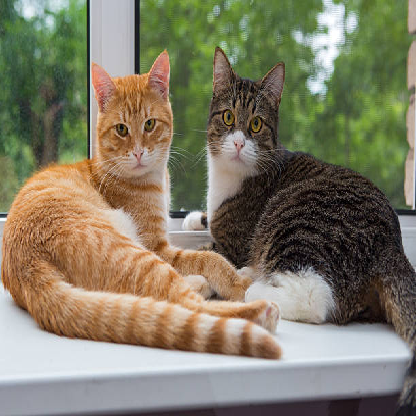

In [76]:
images[0]

In [92]:
# List of labels used for classification
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


anchors = [
    [(116, 90), (156, 198), (373, 326)],  # Large scale (13x13)
    [(30, 61), (62, 45), (59, 119)],     # Medium scale (26x26)
    [(10, 13), (16, 30), (33, 23)]       # Small scale  (52x52)
]

input_dim = 416

confidence_threshold = 0.5

iou_threshold = 0.2

In [84]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def decode_predictions(predictions, anchors, input_dim, confidence_threshold=0.9):
    boxes, scores, classes = [], [], []

    # Match the anchor with every scale
    for scale, anchor_set in zip(predictions, anchors):
        grid_size = scale.shape[1]
        num_anchors = len(anchor_set)
        num_classes = len(labels)

        # Reshape to (batch_size, grid, grid, anchors, attributes)
        scale = scale.reshape((scale.shape[0], grid_size, grid_size, num_anchors, 5 + num_classes))

        # Extract values
        box_xy = sigmoid(scale[..., :2])  # x, y (sigmoid)
        box_wh = np.exp(scale[..., 2:4]) * anchor_set  # width, height of box * anchor
        box_confidence = sigmoid(scale[..., 4:5])  # confidence (sigmoid)
        class_probs = sigmoid(scale[..., 5:])  # class probabilities (sigmoid)

        # Compute box corners
        grid = np.arange(grid_size)
        grid_x, grid_y = np.meshgrid(grid, grid)

        # (grid_size, grid_size, 2) -> (grid_size, grid_size, 1, 2)
        stack_grid = np.stack((grid_x, grid_y), axis=-1)
        box_xy += stack_grid[..., np.newaxis, :]
        
        # Normalize the coordinates
        box_xy /= grid_size
        box_wh /= input_dim
        # (grid_size, grid_size, num_anchors, 4)
        box_coords = np.concatenate((box_xy, box_wh), axis=-1) 


        # Find the maximus score and corresponding class
        box_coords = box_coords.reshape(-1, 4) # (grid_size * grid_size * num_anchors, 4)
        box_scores = (box_confidence * class_probs).reshape(-1, num_classes)
        max_scores = np.max(box_scores, axis=-1)
        max_classes = np.argmax(box_scores, axis=-1)


        # Apply confidence threshold
        mask = max_scores > confidence_threshold
        boxes.append(box_coords[mask])
        scores.append(max_scores[mask])
        classes.append(max_classes[mask])

    # Combine all scales
    return np.concatenate(boxes), np.concatenate(scores), np.concatenate(classes)



In [85]:
def apply_nms(boxes, scores, classes, iou_threshold=0.5, max_boxes=50):
    # Perform non-max supression
    indices = tf.image.non_max_suppression(
        boxes, scores, max_boxes, iou_threshold
    )
    # Filter the elements
    filtered_boxes = tf.gather(boxes, indices)
    filtered_scores = tf.gather(scores, indices)
    filtered_classes = tf.gather(classes, indices)
    return filtered_boxes.numpy(), filtered_scores.numpy(), filtered_classes.numpy()



In [86]:
def draw_boxes(image, boxes, scores, classes, image_i):
    
    height, width = 416, 416

    # Scale boxes back to the original image size
    for box, score, cls in zip(boxes, scores, classes):
        x, y, w, h = box
        left = int((x - w / 2) * width)
        top = int((y - h / 2) * height)
        right = int((x + w / 2) * width)
        bottom = int((y + h / 2) * height)

        # Draw the bounding box
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

        # Add the label
        label = f"{labels[cls]}: {score:.2f}"
        cv2.putText(image, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f'./processed_images/output_image{image_i}.jpg', bbox_inches='tight', pad_inches=0)
    plt.close()



In [93]:
for image_i, img in enumerate(images):
    img = process_image(img)
    predictions = model.predict(img)
    boxes, scores, classes = decode_predictions(predictions, anchors, input_dim, confidence_threshold)
    boxes, scores, classes = apply_nms(boxes, scores, classes, iou_threshold)
    
    draw_boxes(img[0], boxes, scores, classes, image_i)

1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
